In [2]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# Welcome to CARPoolGP! 

This is an emulator that I have been developing and I think with your results from the quenching, we can use CARPoolGP to emulate over some interestin parameters. Ok so first lets walk through the basics of the emulator and how it works. Then we will try to apply it to the use case of Quenching fraction. There is a general structure to CARPoolGP which I will outline below, we can use this as a guide throughout this notebook. I have copy and pasted from a paper we are working on, so sorry if somethings dont make much sense, we can talk them through! 

1. Generate a set of parameters, $B$, at which to extract Base sample quantities $\tilde{Q}$.
2. Generate a set $S$ of Parameter Islands, $\theta_{S}$ at which to extract Surrogate sample quantities, $\tilde{Q}^S$. Ensure that Base-Surrogate pairs have some level of correlation between them. 
3. Determine the noise kernels and associated hyperparameters for Base, Surrogate, and Combined quantities: $C_{ij}$, $D_{ij}$, $X_{ij}$.
4. Maximize the likelihood function (minimize inverse Wishart function) to obtain the optimal set of hyperparameters: $\hat{\tau}$.
5. Emulate to find $ Q(\theta_{p, i}')$, and $\sigma^2(\theta_{p, i}', \theta_{p,j}')$.

# A Toy model to get started

Before even starting with CARPoolGP we need to outline some of the preliminary information... like the model that we are going to use. In practice we are not lucky enough to know the model, otherwise that would defeat the whole purpose... But here as a toy example to get us started we can make this simple. 

We consider some mean quantity, $ Q$, which has a functional form, 

\begin{equation}
\begin{split}
     Q(\theta_{p,i}) &= A \theta_{p,i} + B\theta_{p,i}^3\sin(\theta_{p,i})\\
    \tilde{Q}(\theta_{p,i}) &=  Q(\theta_{p,i})  + \epsilon_{i}
\end{split}
\end{equation}

Where A and B are some constants, and $\theta_i$ is our independent parameter. We choose the dimensionality of our parameter to be 1. We define this model below

In [3]:
def get_Q(theta, A=-0.02, B=0.19):
    """
    This is the model which we ultimitely want to predict, represents the 
    smooth variation on some function. 
    """
    return (A * theta  +  theta**3*B**4 * np.sin(theta))

We need to define some global variables that we will use through out the toy model as well. 

In [4]:
sigma_Q  = 0.2       # jitter ontop of smooth variation
N        =50         # Number of Base data samples
Domain   = [-10,10]  # Domain of parameters
LR       = 1e-5      # Optimization learning rate 
ITERS    = 5000      # maximum no of iteration

Lets make a set of "True" values that we can test our emulator against in the future. This will also show us how the functoin moves through spae

Text(0, 0.5, '$Q$')

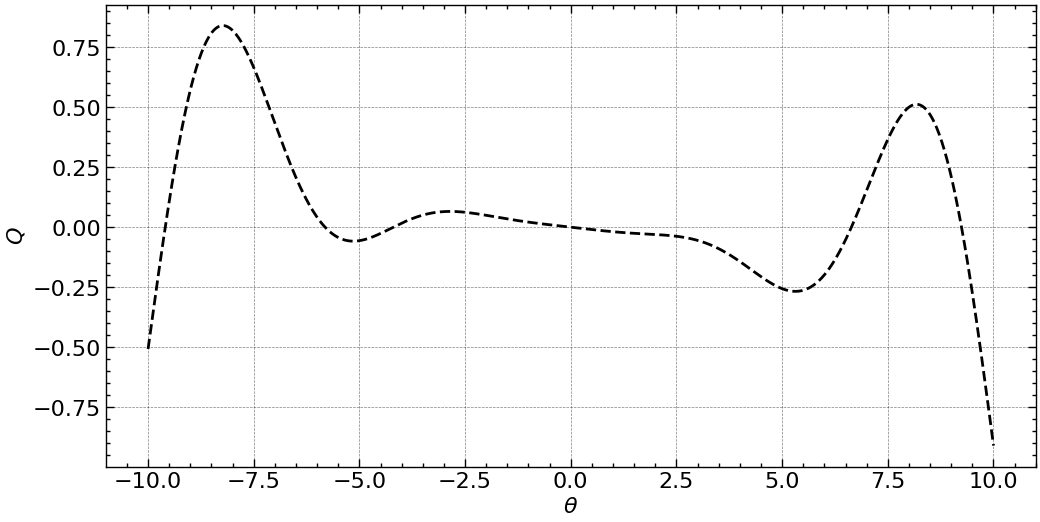

In [5]:
# underlying truth: 
plt.figure(figsize=(12, 6))
theta=np.linspace(*np.array(Domain)+0.001, 1001, endpoint=True)
Y = get_Q(theta) 
plt.plot(theta, Y, 'k--', label='Truth')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$Q$')


## 1. Generate a set of parameters, $B$, at which to extract Base sample quantities $\tilde{Q}$

We build the Base quantities by sampling a uniformly random distribution within the domain $[-10, 10]$ to generate a set of parameters $B\equiv\{{\bf \theta}_{p=1, i}| p=1; i=1, 2, ..., N\}$, and quantities, $\tilde{Q}(\theta_i)$. We choose $N=50$ and draw $\epsilon_{Q,i}$ from a normal distribution with $\langle\epsilon_{Q}\rangle = 0$ and $\langle\epsilon_Q^2\rangle = \sigma_Q^2$. 

In [6]:
def model_data(theta, seed=1993, noise=None):
    """
    Args:
        theta (array) : the set of parameters B
        noise (array)  : an array of noise values to add to the raw Q
        seed (int) : seed used to generate random numbers

    Returns:
        \tilde{Q}: noisey data
        noise : noise added to data. 
    """
    Q = get_Q(theta)
    if noise is not None:
        return Q + noise
    np.random.seed(seed)
    noise = np.random.normal(0, sigma_Q, len(theta))
    return Q+noise, noise

In [7]:
# Sample Data
np.random.seed(194)
theta_B = np.random.uniform(Domain[0], Domain[1], N)
Q_B, intrinsic_noise = model_data(theta_B, 194, None)

## 2. Generate a set $S$ of Parameter Islands, $\theta_{S}$ at which to extract Surrogate sample quantities, $\tilde{Q}^S$. Ensure that Base-Surrogate pairs have some level of correlation between them. 


We then generate Parameter Islands by linearly spacing $N_S=5$ points in the range $[-8, 8]$. For each Base sample, the closest Parameter island is identified, and a  Surrogate sample is drawn, $\tilde{Q}(\theta^S_i)$ where the noise, $\epsilon_{S,i}$ is correlated to the noise from the Base simulation such that 
\begin{equation}
    \epsilon_{S,i} = (1-f)\epsilon_{Q,i} + f\epsilon_{P,i} 
\end{equation}
Where $f$ is some correlation constant that determines the level of noise correlation with the base simulations, $\epsilon_{Q, i}$, is the noise realization of the Base sample, and $\epsilon_{P, i}$ is some new random noise realization. In this example, we set $f=0$ to maximize the correlation between Base and Surrogate simulations.

In [8]:
def match_surrogates(theta_Q, intrinsic_noise, Groups, f=0.0):
    """
    Generate the correlated surrogate samples given the set of groups, the set of base samples and the noise

    Args:
        theta_Q (array): base samples
        intrinsic_noise (array): noise associated with tilde{Q}
        Groups (int): number of groups
        f (float: _description_. Defaults to 0.

    Returns:
        theta_S, and S
    """
    Surrogate_locs = np.linspace(-8, 8, Groups, endpoint=True)
    nearest_island = np.zeros_like(theta_Q)
    for i, pi in enumerate(theta_Q):
        nearest_island[i] = Surrogate_locs[np.argmin((pi - Surrogate_locs)**2)]
    S_raw = get_Q(nearest_island)
    S = S_raw + intrinsic_noise*(1-f) + f*np.random.normal(0, sigma_Q, len(S_raw))
    return nearest_island, S

In [9]:
theta_S, Q_S = match_surrogates(theta_B, intrinsic_noise, Groups=5, f=0)

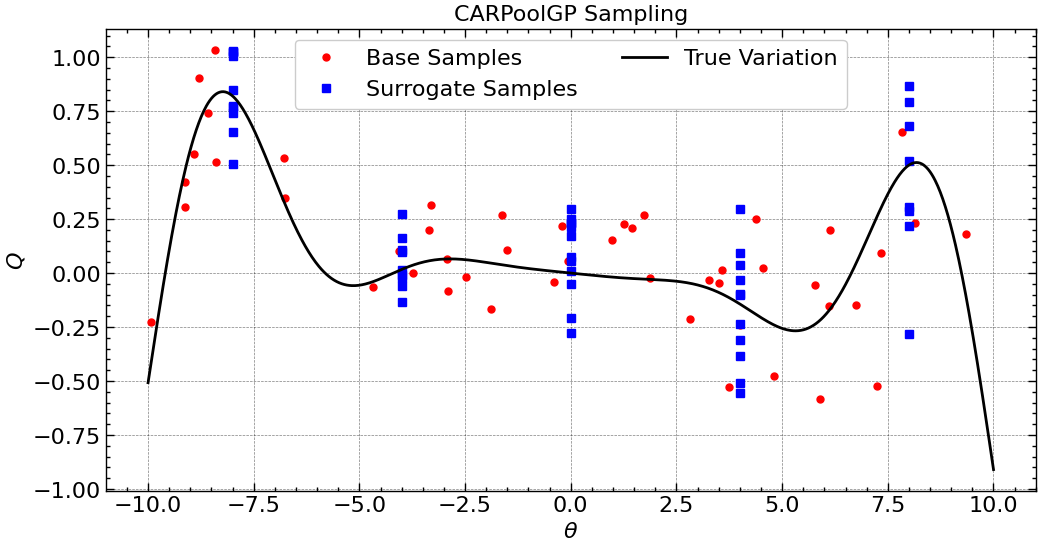

In [10]:
fig, axs = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(12,6), gridspec_kw={'wspace':0.02})
axs.plot(theta_B, Q_B, 'o', color='r', markersize=5, label='Base Samples')
axs.plot(theta_S, Q_S, 's', color='b', label='Surrogate Samples')
axs.plot(theta, Y, 'k', label='True Variation')
axs.set_title('CARPoolGP Sampling')
axs.set_xlabel(r'$\theta$')
axs.set_ylabel('$Q$')
axs.legend(ncol=2, loc='upper center')



## 3. Determine the noise kernels and associated hyperparameters for Base, Surrogate, and Combined quantities: $C_{ij}$, $D_{ij}$, $X_{ij}$.


For both the Base and Surrogate samples, we use a radial basis function defined in Eq.~\ref{eq:rbf} to describe the smooth varying component of the covariance.
%
\begin{equation}
\begin{split}
    V_{ij} = \alpha_B\exp\left(-\gamma_B \, d_E(\theta_{i} - \theta_{j})^2\right)\\
    W_{ij} = \alpha_S\exp\left(-\gamma_S \, d_E(\theta_{i} - \theta_{j})^2\right)
\end{split}
\end{equation}

Where the hyperparameters, $\alpha_B$ and $\gamma_B$ contain the subscript, $B$, to make clear that this kernel only acts on the Base samples, and similarly, $\alpha_S$ and $\gamma_S$ act independently on the Surrogate samples. The Base samples are all uncorrelated from one another in their sample variance, and the same is true for the Surrogate samples

\begin{equation}
\begin{split}
    C_{ij} &= \alpha_B\exp\left(-\gamma_B \, d_E(\theta_{i} - \theta_{j})^2\right) + \sigma_B^2\mathcal{I}\\
    D_{ij} &= \alpha_S\exp\left(-\gamma_S \, d_E(\theta_{i} - \theta_{j})^2\right) + \sigma_S^2\mathcal{I}
\end{split}
\end{equation}

We choose the kernel describing the smooth covariance between the Base and Surrogate samples to be an RBF similarly, but with an additional parameter, $\Delta q_{BS}$, which is non-zero for parameters run at the same location in parameter space but with different underlying functional forms (see the discussion in section~\ref{sec:CPTheory}). 

\begin{equation}
    Y_{ij} = \alpha_Y\exp\left(-\gamma_Y \, \left(d_E(\theta_{i} - \theta_{j})^2 + \Delta q_{BS}\right)\right)\\    
\end{equation}

For the fast-varying covariance, we choose a linear exponential kernel with an amplitude that is related to the Base and Surrogate sample variances through, 
\begin{equation}
    M_{ij} = \sigma_B\sigma_S\exp\left(-\gamma_M \, d_E(\theta_{i} - \theta_{j})\right)
\end{equation}
Recall, that the distance in $Y_{ij}$ and $M_{ij}$ are evaluated between Base and Surrogate samples.

we then have
\begin{equation}
\begin{split}
    X_{ij} = &\alpha_Y\exp\left(-\gamma_Y \, \left(d_E(\theta_{i} - \theta_{j})^2 + \Delta q_{BS}\right)\right) +\\ &\sigma_B\sigma_S\exp\left(-\gamma_M \, d_E(\theta_{i} - \theta_{j})\right)
\end{split}
\end{equation}
We can now build the block covariance matrix containing all of these components following Eq.~\ref{eq:sigma} where $\tau$ is the vector of hyperparameters, $\tau=(\alpha_B, \alpha_S, \alpha_Y, \gamma_B, \gamma_S, \gamma_Y, \gamma_M, \Delta q_{BS}, \sigma^2_B, \sigma^2_S )$

All of these kernels are taken care of internally by CARPoolGP. So what we have to do is define the simulations and surrogates which we can do as follows:

In [11]:
from src import CARPoolSimulations
from src import CARPoolEmulator


# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_B  ;  sims.quantities  = Q_B
surrs.parameters = theta_S  ;  surrs.quantities = Q_S

#Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) 
emu = CARPoolEmulator.Emulator(sims, surrs)

## 4. Maximize the likelihood function (minimize inverse Wishart function) to obtain the optimal set of hyperparameters: $\hat{\tau}$.

We use the Gaussian likelihood function as defined below and choose uninformative priors for $\mu_B$ and $\mu_S$, but allow them to be learned as additional hyperparameters in the regression. We then minimize the negative log of the likelihood function to obtain an optimal set of hyperparameters, $\hat{\tau}$ using Stochastic Gradient Descent (SGD).

\begin{equation}
\begin{split}
    \mathcal{L}(\tau) = &\frac{1}{(2\pi)^{N/2}} |\Sigma(\tau)|^{-1/2}\,\times \exp\left(-\frac{1}{2}\begin{pmatrix}
        \tilde{Q}-\mu_Q\\
        \tilde{Q}^S-\mu_S
        \end{pmatrix}^T \Sigma(\tau)^{-1}\begin{pmatrix}
        \tilde{Q}-\mu_Q\\
        \tilde{Q}^S-\mu_S
        \end{pmatrix}\right)
\end{split}
\end{equation}

In [12]:
params = {"log_scaleV":0.0, "log_ampV":0.0, "log_scaleW":0.0, "log_ampW":0.0, "log_scaleX":0.0, "log_ampX":-5.0, 
          "log_scaleM":0.0, "log_deltaP":-0.0, "log_jitterV":-3.0, "log_jitterW":-3.0, "log_mean":0.0}

# Train the emulator
best_params = emu.train(params, learning_rate=LR, max_iterations=ITERS)

## 5. Emulate to find $ Q(\theta_{p, i}')$, and $\sigma^2(\theta_{p, i}', \theta_{p,j}')$.

We now have all we need to perform an emulation at sample points from the set $T$ using:

\begin{equation}
\begin{split}
     Q(\theta_{p, i}')  & = \text{K}_s(\hat{\tau})\, \Sigma^{-1}_{ij}(\hat{\tau}) \begin{pmatrix}
        \tilde{Q}-\mu_Q\\
        \tilde{Q}^S-\mu_S
        \end{pmatrix} + \begin{pmatrix}
        \mu_Q\\
        \mu_S
        \end{pmatrix}\\
    \sigma^2(\theta_{p, i}', \theta_{p, j}') & = \text{K}_{tt}(\hat{\tau}) - \text{K}_t(\hat{\tau})\Sigma_{ij}^{-1}(\hat{\tau})\text{K}_t^T(\hat{\tau})
\end{split}
\end{equation}


With 

\begin{equation}
    \begin{split}
        \text{K}_t(\hat{\tau}) &= \Sigma(\theta_{p,i}', \theta_{p,j} ; \hat{\tau})\\
        \text{K}_{tt}(\hat{\tau}) &= \begin{pmatrix}
            V(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) \,\,\, Y(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) \\
            Y^T(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) \, W(\theta_{p,i}', \theta_{p,j}' ; \hat{\tau}) 
        \end{pmatrix}\\
    \end{split}
\end{equation}

All of this is taken care by the package

In [13]:
# now emulate! 
pred_mean, pred_var = emu.predict(theta)

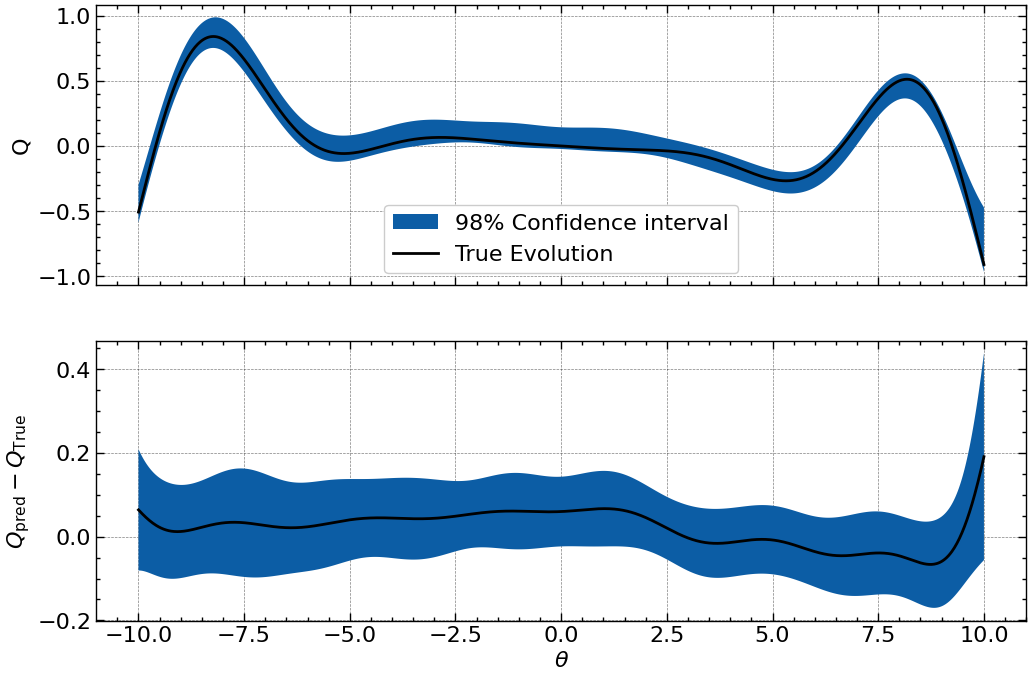

In [14]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
std = np.sqrt(np.diag(pred_var))
axs[0].fill_between(theta, pred_mean - 2*std, pred_mean+2*std, label='98% Confidence interval')
axs[0].plot(theta, Y, 'k', label='True Evolution')

axs[1].fill_between(theta, (pred_mean-Y) - 2*std, (pred_mean-Y)+2*std, label='98% Confidence interval')
axs[1].plot(theta, (pred_mean - Y), 'k', label='Residual')
axs[0].set_ylabel('Q')
axs[1].set_xlabel(r'$\theta$')
axs[1].set_ylabel(r'$Q_{\rm pred} - Q_{\rm True}$')
axs[0].legend()


# Data application 

So now we want to perform the exact same thing but on data! Lets go through each of the steps then. 

## 1. Generate a set of parameters, $B$, at which to extract Base sample quantities $\tilde{Q}$

I have saved the currently used parameters from the sims in the ```Data/PARAMS.txt``` file. So you can access this easily. But these parameter files are a little tricky because they are used to write zoom-in simulation files. So take care with reading them in. The first parameter is just an index. Then the next 28 parameters are as in SB28 set. The second to last parameter is the mass parameter in units of $10^{14}M_\odot$ Also... They are strs and space seperated.

Note that not all of the simulations have finished! the number of the index corresponds to the index number in the parameters file. so if you are missing zoom_64, then theta_B[64] should not be used

In [15]:
def extract_params(line):
    params = line.split(' ')[1:29]
    params.append(line.split(' ')[35])
    return np.array(params, dtype='float')

In [16]:
with open('Data/PARAMS.txt', 'r') as file:
    lines = file.readlines()
theta_raw = np.array([extract_params(line) for line in lines])

We also need to account for the parameters that have been logged, It is also good to normalize the data, this way we dont get a sing parameter that is doing all the work

In [17]:
import pandas as pd
theta = theta_raw.copy()
param_info = pd.read_csv('Data/SB28_param_minmax.csv')
for i, t in enumerate(theta_raw[:, :-1].T):
    if bool(param_info['LogFlag'][i]):
        theta[:, i] = np.log10(theta_raw[:, i])

Now one important thing to note... **The mass that we want for our parameters, is NOT the mass that we typically get from the simulations!** it may be close, but is not exact. This means you will have to change the last value in the theta array to match the true masses of the halos that were generated. 

## 2. Generate a set $S$ of Parameter Islands, $\theta_{S}$ at which to extract Surrogate sample quantities, $\tilde{Q}^S$. Ensure that Base-Surrogate pairs have some level of correlation between them. 


The above gave us 512 parameter lines, but not all of these are Base simulations. Some correspond to surrogates. So we need to seperate them appropriately. We can do this by recognizing that the base/surrogates are organized by line where, 

IF (line // 128 ) Mod 2 == 1: Surrogate

IF (line // 128 ) Mod 2 == 0: Base

In [18]:
def BS_organizer(N, thetas):
    theta_S = []
    theta_B = []
    for i, theta in zip(N, thetas):
        if (i//128)%2 ==0:
            theta_B.append(theta)
        elif (i//128)%2 ==1:
            theta_S.append(theta)
        else:
            raise Exception("Somethings totally wrong")
    return np.array(theta_B), np.array(theta_S)

In [19]:
theta_B, theta_S = BS_organizer(np.arange(len(theta)), theta)

We now want to read the data in from your file. So read it in and split it in the same way. There should be a dataset for the theta_B and a dataset for theta_S.

It is not completely necessary, but it helps if you line pairs of data up, i.e. Q_S[i] is the surrogate of Q_B[i]. If one or the other does not exist, then place them at the end of the array. I show an example below for a different quantity. 

This is all because the zooms are not finished yet. This will be much more streamlined in the next monthish. So this is a little hacky for right now. But it will do the job

In [20]:
def BS_matcher(N_B, N_S, base, surrogate):
    bases, surrogates = [], []
    for i, b in enumerate(N_B):
        if b+128 in N_S:
            bases.append(i)
            j = np.where(b+128 == N_S)[0][0]
            surrogates.append(j)
    base = np.concatenate((base[np.array(bases)], base[np.delete(np.arange(len(base)), bases)]))
    surrogate = np.concatenate((surrogate[np.array(surrogates)], surrogate[np.delete(np.arange(len(surrogate)), surrogates)]))
    return base, surrogate

In [107]:
# Organize the data a bit

data = np.load('Data/sims.npz')
usable_indices = np.nonzero(data['Y'])

Ysz      = np.log10(data['Y'][usable_indices])
Mass     = np.log10(data['M'][usable_indices]*1e10)
zoom_num = data['N'][usable_indices]

usable_theta        = theta[zoom_num]
usable_theta[:, -1] = Mass
usable_theta_normalized = (usable_theta - usable_theta.min(axis=0)) / (usable_theta.min(axis=0) - usable_theta.max(axis=0)) + 1 #Normalizes to between 0 and 1

theta_B, theta_S  = BS_organizer(zoom_num, usable_theta_normalized) 
Q_B, Q_S          = BS_organizer(zoom_num, Ysz) 
N_B, N_S          = BS_organizer(zoom_num,zoom_num)
Q_B, Q_S          = BS_matcher(N_B, N_S, Q_B, Q_S)
theta_B, theta_S  = BS_matcher(N_B, N_S, theta_B, theta_S)

## 3. Determine the noise kernels and associated hyperparameters for Base, Surrogate, and Combined quantities: $C_{ij}$, $D_{ij}$, $X_{ij}$.


We are going to use the same kernels as in the toy example, but with extra dimensions on the parameters. So all we need to do is generate the simulation, surrogate, and emulation objects:


In [108]:
# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_B  ;  sims.quantities  = Q_B
surrs.parameters = theta_S  ;  surrs.quantities = Q_S

#Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) 
emu = CARPoolEmulator.Emulator(sims, surrs)

## 4. Maximize the likelihood function (minimize inverse Wishart function) to obtain the optimal set of hyperparameters: $\hat{\tau}$.

We need to generate some initial guess of the parameters, and then we can emulate! feel free to mess around with the initial conditions, as the minimization can be sensitive to this sometimes. 

In [122]:
params = {"log_scaleV"   :3*np.ones(emu.param_dimensions),
        "log_scaleX" :0*np.ones(emu.param_dimensions),
        "log_scaleW" : 3*np.ones(emu.param_dimensions),
        "log_scaleM" :1*np.ones(emu.param_dimensions),
        "log_ampV"   :0.0*np.ones(emu.param_dimensions),
        "log_ampW"   :0.0*np.ones(emu.param_dimensions),
        "log_ampX"   :0.0*np.ones(emu.param_dimensions),                
        "log_deltaP" :0*np.ones(emu.param_dimensions),
        "log_jitterV":-2.0,
        "log_jitterW":-2.0,
        "log_mean"   :-1.0}

best_params = emu.train(params,learning_rate=LR, max_iterations=1000)

Text(0, 0.5, 'Loss')

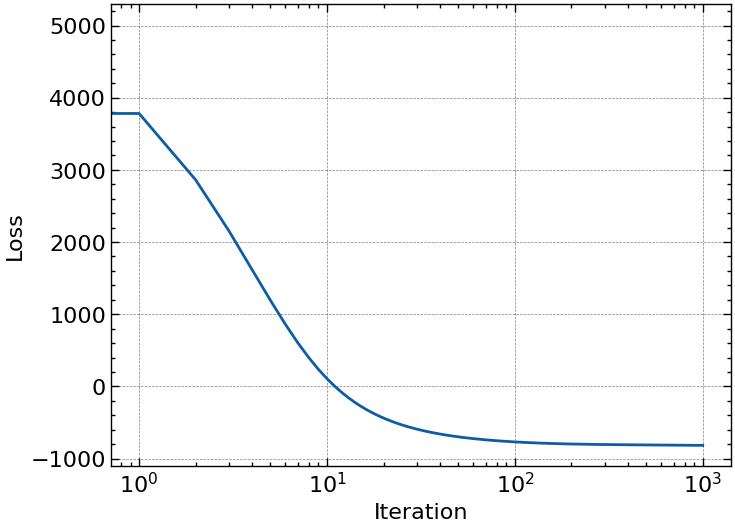

In [123]:
plt.semilogx(emu.losses[-1])
plt.xlabel('Iteration')
plt.ylabel('Loss')

## 5. Emulate to find $ Q(\theta_{p, i}')$, and $\sigma^2(\theta_{p, i}', \theta_{p,j}')$.

If for example we are interested in the variation just with respect to the parameter, Omega_0. We could set all the values to some fiducial and just vary this. 

In [124]:
P = 0

theta_test = np.ones((1000, 29)) * 0.91
theta_test[:, P] = np.linspace(0, 1, 1000)
pred_mean, pred_var = emu.predict(theta_test)

(-9.0, -3.0)

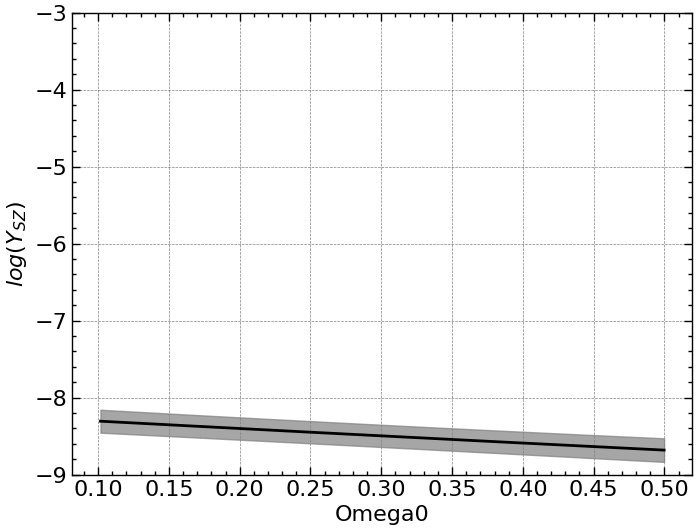

In [125]:
# Put the parameter back into physical units
x = (theta_test[:, P] - 1) * (usable_theta[:, P].min() - usable_theta[:, P].max()) + usable_theta[:, P].min()
if P<28:
    if bool(param_info['LogFlag'][P]) == True:
        x = 10**x

plt.plot(x, pred_mean, color='k')
std = np.diag(pred_var)**(0.5)
plt.fill_between(x, pred_mean-std, pred_mean + std, color='grey', alpha=0.7)
if P<28:
    plt.xlabel(param_info['ParamName'][P])
else:
    plt.xlabel('Mass')
plt.ylabel(r'$log(Y_{SZ})$')

plt.ylim(-9, -3)

In [86]:
import numpy as np

In [87]:
rusty = np.load('Data/Rusty.npz')
popeye = np.load('Data/PopeyeSims1.npz')

In [100]:
usable_indicesr = np.nonzero(rusty['Y'])
popeye_over256 = popeye['N'] > 256
usable_indicesp = np.nonzero(popeye['Y'][popeye_over256])

In [101]:
super_dict = {}
for file in rusty.files:
    super_dict[file] = rusty[file][usable_indicesr]
    
for file in popeye.files:
    dat = popeye[file][popeye_over256]
    super_dict[file] = np.concatenate((super_dict[file], dat[usable_indicesp]))

In [105]:
popeye.files

['T', 'Y', 'P', 'S', 'M', 'R', 'N']

In [106]:
np.savez('sims', T=super_dict['T'], Y=super_dict['Y'], P=super_dict['P'], S=super_dict['S'], M=super_dict['M'], R=super_dict['R'], N=super_dict['N'])